In [1]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as models
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

In [13]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [14]:
# Define dataset and data loaders for training and validation
train_dataset = ImageFolder('C:/Users/vaish/MSBA Files/Advanced Machine Learning/AML Project/chest_xray_reshuffle/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataset = ImageFolder('C:/Users/vaish/MSBA Files/Advanced Machine Learning/AML Project/chest_xray_reshuffle/val', transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=32)

### ResNet

In [15]:
# Initialize a ResNet model
model = models.resnet18(pretrained=True)
# Modify the output layer to match your binary classification task
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 output classes (pneumonia present or not)
model

C:\Users\vaish\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vaish\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a function for training the model
def train_model(model, train_loader, criterion, optimizer, validation_loader, num_epochs=50):
    train_accuracy_list = []
    validation_accuracy_list = []
    validation_precision_list = []
    validation_recall_list = []
    validation_f1_list = []
    validation_auc_list = []
    validation_auc_pr_list = []
    validation_loss_list = []
    train_loss_list = []

    for epoch in range(num_epochs):
        print("Epoch", epoch)
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(total_loss/len(train_loader))  # Store training loss
        
        # Print and store training accuracy
        print(f'Training - Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss/len(train_loader)}, Accuracy: {train_accuracy}%')

        # Validation loop
        validation_accuracy, validation_loss, precision, recall, f1, auc, auc_pr = test_model(model, validation_loader)
        validation_accuracy_list.append(validation_accuracy)
        validation_loss_list.append(validation_loss)  # Store validation loss
        validation_precision_list.append(precision)
        validation_recall_list.append(recall)
        validation_f1_list.append(f1)
        validation_auc_list.append(auc)
        validation_auc_pr_list.append(auc_pr)
        
        # Save the model after each epoch
        # torch.save(model.state_dict(), save_path.format(epoch+1))

        # Print and store validation metrics
        print(f'Validation - Epoch {epoch + 1}/{num_epochs}, Loss: {validation_loss:.4f}')
        print(f'Validation - Epoch {epoch + 1}/{num_epochs}, Accuracy: {validation_accuracy:.2f}%')
        print(f'Validation - Epoch {epoch + 1}/{num_epochs}, Precision: {precision:.4f}')
        print(f'Validation - Epoch {epoch + 1}/{num_epochs}, Recall: {recall:.4f}')
        print(f'Validation - Epoch {epoch + 1}/{num_epochs}, F1 Score: {f1:.4f}')
        print(f'Validation - Epoch {epoch + 1}/{num_epochs}, AUC: {auc:.4f}')
        print(f'Validation - Epoch {epoch + 1}/{num_epochs}, AUC-PR: {auc_pr:.4f}')

    return train_accuracy_list, validation_accuracy_list, train_loss_list, validation_loss_list, validation_precision_list, validation_recall_list, validation_f1_list, validation_auc_list, validation_auc_pr_list



def test_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    total_loss = 0.0  # Added for validation loss

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Calculate validation loss
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save predictions and true labels
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    accuracy = 100 * correct / total
    average_loss = total_loss / len(data_loader)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc = roc_auc_score(true_labels, predictions)
    auc_pr = average_precision_score(true_labels, predictions)

    return accuracy, average_loss, precision, recall, f1, auc, auc_pr

In [17]:
train_accuracy_per_epoch, validation_accuracy_per_epoch, train_loss_per_epoch, validation_loss_per_epoch, validation_precision_per_epoch, validation_recall_per_epoch, validation_f1_per_epoch, validation_auc_per_epoch, validation_auc_pr_per_epoch = train_model(model, train_loader, criterion, optimizer, validation_loader, num_epochs=50)

Epoch 0
Training - Epoch 1/50, Loss: 0.12763234648178806, Accuracy: 95.13444302176697%
Validation - Epoch 1/50, Loss: 0.4391
Validation - Epoch 1/50, Accuracy: 89.23%
Validation - Epoch 1/50, Precision: 0.8776
Validation - Epoch 1/50, Recall: 0.9906
Validation - Epoch 1/50, F1 Score: 0.9307
Validation - Epoch 1/50, AUC: 0.8086
Validation - Epoch 1/50, AUC-PR: 0.8762
Epoch 1
Training - Epoch 2/50, Loss: 0.06807112690222887, Accuracy: 97.60990183525395%
Validation - Epoch 2/50, Loss: 1.2133
Validation - Epoch 2/50, Accuracy: 74.53%
Validation - Epoch 2/50, Precision: 0.9964
Validation - Epoch 2/50, Recall: 0.6534
Validation - Epoch 2/50, F1 Score: 0.7893
Validation - Epoch 2/50, AUC: 0.8235
Validation - Epoch 2/50, AUC-PR: 0.9041
Epoch 2
Training - Epoch 3/50, Loss: 0.04087010668083823, Accuracy: 98.33546734955186%
Validation - Epoch 3/50, Loss: 0.3190
Validation - Epoch 3/50, Accuracy: 92.14%
Validation - Epoch 3/50, Precision: 0.9262
Validation - Epoch 3/50, Recall: 0.9696
Validation -

Training - Epoch 23/50, Loss: 0.013212650263953112, Accuracy: 99.50917626973965%
Validation - Epoch 23/50, Loss: 0.6355
Validation - Epoch 23/50, Accuracy: 89.74%
Validation - Epoch 23/50, Precision: 0.8815
Validation - Epoch 23/50, Recall: 0.9930
Validation - Epoch 23/50, F1 Score: 0.9339
Validation - Epoch 23/50, AUC: 0.8161
Validation - Epoch 23/50, AUC-PR: 0.8804
Epoch 23
Training - Epoch 24/50, Loss: 0.008306394409741881, Accuracy: 99.67989756722152%
Validation - Epoch 24/50, Loss: 0.4690
Validation - Epoch 24/50, Accuracy: 91.97%
Validation - Epoch 24/50, Precision: 0.9060
Validation - Epoch 24/50, Recall: 0.9930
Validation - Epoch 24/50, F1 Score: 0.9475
Validation - Epoch 24/50, AUC: 0.8572
Validation - Epoch 24/50, AUC-PR: 0.9047
Epoch 24
Training - Epoch 25/50, Loss: 0.015498743718220558, Accuracy: 99.46649594536919%
Validation - Epoch 25/50, Loss: 1.1543
Validation - Epoch 25/50, Accuracy: 84.96%
Validation - Epoch 25/50, Precision: 0.8291
Validation - Epoch 25/50, Recall: 1

Training - Epoch 45/50, Loss: 4.7787347319316734e-05, Accuracy: 100.0%
Validation - Epoch 45/50, Loss: 0.5472
Validation - Epoch 45/50, Accuracy: 92.48%
Validation - Epoch 45/50, Precision: 0.9118
Validation - Epoch 45/50, Recall: 0.9930
Validation - Epoch 45/50, F1 Score: 0.9507
Validation - Epoch 45/50, AUC: 0.8667
Validation - Epoch 45/50, AUC-PR: 0.9105
Epoch 45
Training - Epoch 46/50, Loss: 4.721911107747421e-05, Accuracy: 100.0%
Validation - Epoch 46/50, Loss: 0.5458
Validation - Epoch 46/50, Accuracy: 92.65%
Validation - Epoch 46/50, Precision: 0.9138
Validation - Epoch 46/50, Recall: 0.9930
Validation - Epoch 46/50, F1 Score: 0.9517
Validation - Epoch 46/50, AUC: 0.8699
Validation - Epoch 46/50, AUC-PR: 0.9125
Epoch 46
Training - Epoch 47/50, Loss: 6.50453633653376e-05, Accuracy: 100.0%
Validation - Epoch 47/50, Loss: 0.5972
Validation - Epoch 47/50, Accuracy: 92.14%
Validation - Epoch 47/50, Precision: 0.9079
Validation - Epoch 47/50, Recall: 0.9930
Validation - Epoch 47/50, F

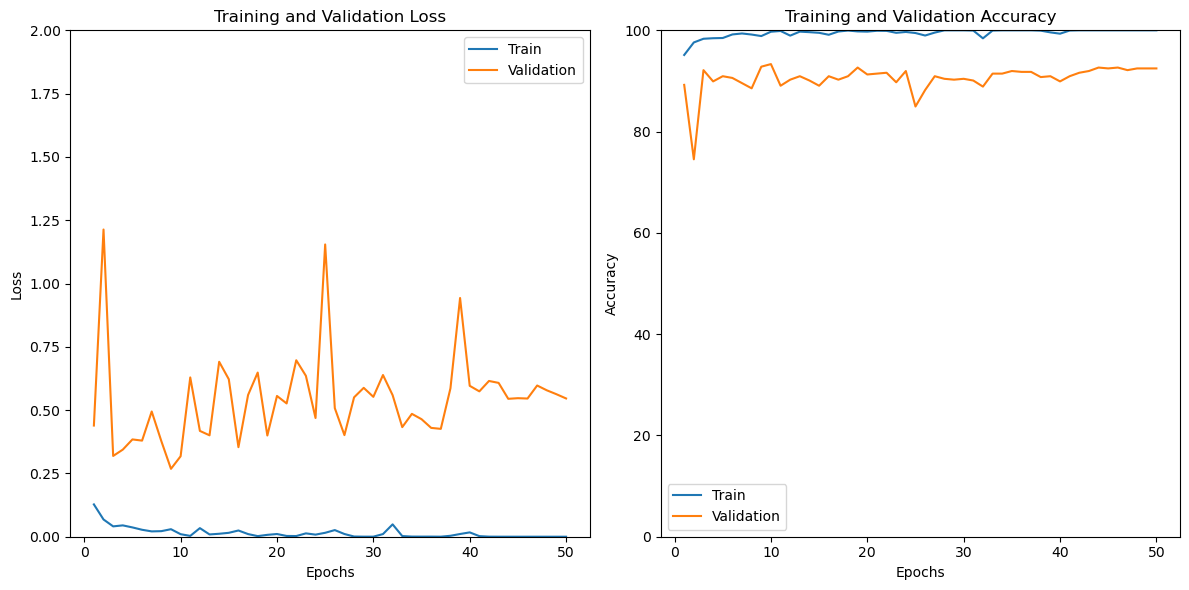

In [31]:
import matplotlib.pyplot as plt
import numpy as np

num_epochs=50
# Assuming you have the following lists
epochs = np.arange(1, num_epochs + 1)
train_loss = train_loss_per_epoch
validation_loss = validation_loss_per_epoch
train_accuracy = train_accuracy_per_epoch
validation_accuracy = validation_accuracy_per_epoch

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train')
plt.plot(epochs, validation_loss, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 2)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train')
plt.plot(epochs, validation_accuracy, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

In [24]:
# Create a DataFrame for training accuracy
train_epoch_list = list(range(1, len(train_accuracy_per_epoch) + 1))
train_df = pd.DataFrame({'Epoch': train_epoch_list, 'Train Accuracy': train_accuracy_per_epoch})

# Display the training DataFrame
print(train_df)

# Save the training accuracy DataFrame to a CSV file
train_df.to_csv('train_accuracy_results_resnet18_0.1_32_10_false.csv', index=False)

# Create a DataFrame for validation accuracy
val_epoch_list = list(range(1, len(validation_accuracy_per_epoch) + 1))
val_df = pd.DataFrame({'Epoch': val_epoch_list, 'Validation Accuracy': validation_accuracy_per_epoch})

# Display the validation DataFrame
print(val_df)

    Epoch  Train Accuracy
0       1       95.134443
1       2       97.609902
2       3       98.335467
3       4       98.442168
4       5       98.484848
5       6       99.189074
6       7       99.381135
7       8       99.167734
8       9       98.868971
9      10       99.722578
10     11       99.871959
11     12       98.954332
12     13       99.743918
13     14       99.637217
14     15       99.509176
15     16       99.125053
16     17       99.765258
17     18       99.957320
18     19       99.786598
19     20       99.743918
20     21       99.914639
21     22       99.893299
22     23       99.509176
23     24       99.679898
24     25       99.466496
25     26       98.975672
26     27       99.551857
27     28      100.000000
28     29      100.000000
29     30      100.000000
30     31       99.957320
31     32       98.420828
32     33       99.957320
33     34      100.000000
34     35      100.000000
35     36      100.000000
36     37      100.000000
37     38   

In [25]:
# Save the validation accuracy DataFrame to a CSV file
val_df.to_csv('val_accuracy_results_resnet18_0.1_32_50_true.csv', index=False)

In [26]:
torch.save(model.state_dict(), 'resnet18_model_weights_0.1_32_50_true.pth')

In [27]:
# Define a data loader for the test set
test_dataset = ImageFolder('C:/Users/vaish/MSBA Files/Advanced Machine Learning/AML Project/chest_xray_reshuffle/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)

In [29]:
# Test the model on the test set
test_accuracy, test_average_loss, precision, recall, f1, auc, auc_pr = test_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'AUC-PR: {auc_pr:.4f}')

Test Accuracy: 83.93%
Precision: 0.8208
Recall: 0.9977
F1 Score: 0.9006
AUC: 0.7045
AUC-PR: 0.8206


In [30]:
test_df = pd.DataFrame({
    'Test Accuracy': [test_accuracy]
})
test_df.to_csv('test_accuracy_results_resnet18_0.1_32_50_true.csv', index=False)

Testing saved model on test set

In [32]:
# Load the saved model weights
model.load_state_dict(torch.load('resnet18_model_weights_0.1_32_18_true.pth'))

<All keys matched successfully>

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')